# Import Library

In [1]:
from collections import Counter
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Đọc dữ liệu

In [2]:
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')

In [3]:
train_data.columns
val_data.columns

Index(['Unnamed: 0', 'Message ID', 'Subject', 'Message', 'Spam/Ham', 'split'], dtype='object')

In [4]:
train_data.head()

,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,-0.055438
4,5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,-0.419658


In [5]:
val_data.head()

,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-0.351998
1,24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham,0.257704
2,32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham,0.091200
3,37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham,-1.745133
4,43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-1.911987


# 2. Tiền xử lý dữ liệu

In [6]:
train_data.rename(columns={'Spam/Ham':'Label'}, inplace=True)
val_data.rename(columns={'Spam/Ham':'Label'}, inplace=True)

In [7]:
# Loại bỏ trường không cần thiết
train_data.drop(columns=['Unnamed: 0', 'Message ID', 'split'], inplace=True)
val_data.drop(columns=['Unnamed: 0', 'Message ID', 'split'], inplace=True)
# Rename trường spam/ham
train_data.rename(columns={'Spam/Ham':'Label'}, inplace=True)
val_data.rename(columns={'Spam/Ham':'Label'}, inplace=True)

In [8]:
# loại bỏ dòng trống
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)
np.sum(val_data['Subject'].isnull() | val_data['Message'].isnull())

0

In [9]:
# loại bỏ các dòng lặp
train_data.drop_duplicates(inplace=True)
val_data.drop_duplicates(inplace=True)
np.sum(train_data.duplicated())
np.sum(val_data.duplicated())

0

In [10]:
# Gom 2 trường Subject và Message làm 1 để xử lý
train_data['Text'] = train_data['Subject'] + ' ' + train_data['Message']
train_data['Label'] = train_data['Label'].apply(lambda x: 1 if x == 'spam' else 0)
val_data['Text'] = val_data['Subject'] + ' ' + val_data['Message']
val_data['Label'] = val_data['Label'].apply(lambda x: 1 if x == 'spam' else 0)

In [11]:
# chuẩn hóa sang dạng lowercase, xóa dấu câu, số
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    #words = [word for word in words if word not in stop_words]
    return ' '.join(words)

train_data['Text'] = train_data['Text'].apply(clean_text)
val_data['Text'] = val_data['Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Phân tích dữ liệu

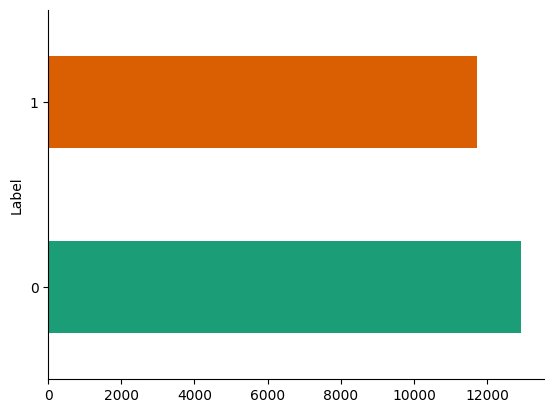

In [12]:
train_data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

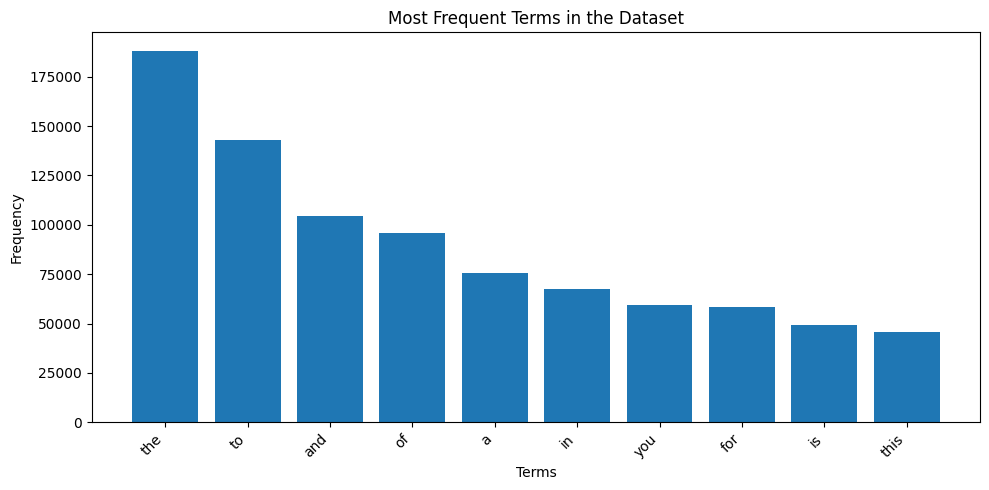

In [13]:
all_text = ' '.join(train_data['Text'])

# Tokenize the text and count word frequencies
words = all_text.split()
word_counts = Counter(words)


most_frequent_terms = word_counts.most_common(10)

# Extract terms and counts
terms, counts = zip(*most_frequent_terms)

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(terms, counts)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Most Frequent Terms in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [14]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)
train_data['Text'] = train_data['Text'].apply(remove_stopword)
val_data['Text'] = val_data['Text'].apply(remove_stopword)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


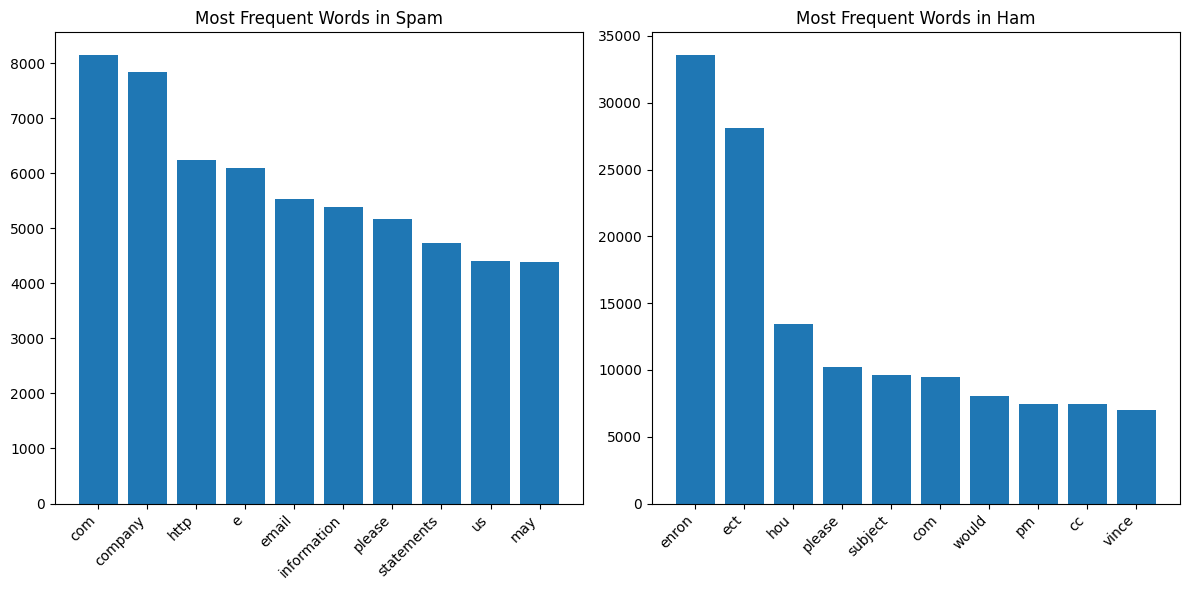

In [15]:
spam_messages = train_data[train_data['Label'] == 1]['Text']
ham_messages = train_data[train_data['Label'] == 0]['Text']


spam_words = ' '.join(spam_messages).split()
ham_words = ' '.join(ham_messages).split()

spam_word_counts = Counter(spam_words)
ham_word_counts = Counter(ham_words)

# Get the top 10 most frequent words
top_spam_words = spam_word_counts.most_common(10)
top_ham_words = ham_word_counts.most_common(10)

# Create bar plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
words, counts = zip(*top_spam_words)
plt.bar(words, counts)
plt.title('Most Frequent Words in Spam')
plt.xticks(rotation=45, ha='right')


plt.subplot(1, 2, 2)
words, counts = zip(*top_ham_words)
plt.bar(words, counts)
plt.title('Most Frequent Words in Ham')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

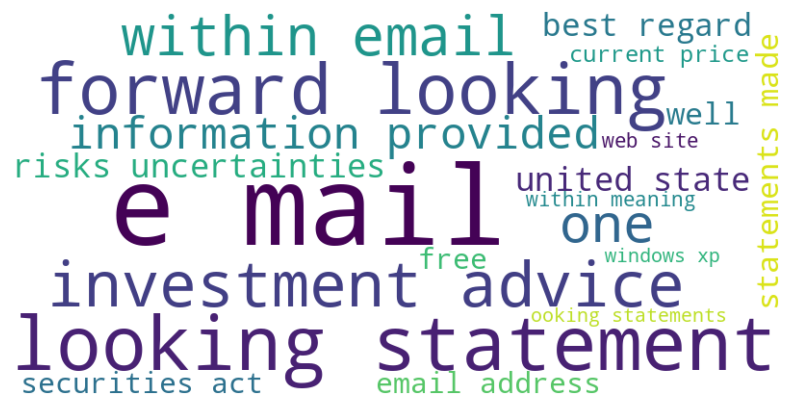

In [16]:
spam_messages = train_data[train_data['Label'] == 1]['Text'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=20).generate(spam_messages)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 3. Huấn luyện mô hình

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Apply TF-IDF to the cleaned text
X_train = tfidf.fit_transform(train_data['Text']).toarray()
X_test = tfidf.transform(val_data['Text']).toarray()

# Labels (1 for spam, 0 for ham)
y_train = train_data['Label']
y_test = val_data['Label']

# Model selection and training (e.g., Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [18]:
#print result
y_pred = model.predict(X_train)
print("Result on train set:")
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'f1-score: {f1:.3f}')

print("\nResult on test set:")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'f1-score: {f1:.3f}')


Result on train set:
Accuracy: 0.992
Precision: 0.993
Recall: 0.990
f1-score: 0.992

Result on test set:
Accuracy: 0.991
Precision: 0.992
Recall: 0.990
f1-score: 0.991


In [19]:
# save model
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 4. Thử nghiệm thực tế

In [20]:
# Tải mô hình
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [21]:
import ipywidgets as widgets
from IPython.display import display

def predict_spam(subject, message):
    text = subject + ' ' + message
    text = clean_text(text)
    X_input = tfidf.transform([text]).toarray()
    prediction = model.predict(X_input)[0]
    return "Spam" if prediction else "Ham"

# Create input widgets
subject_input = widgets.Text(description="Subject:")
message_input = widgets.Textarea(description="Message:")
predict_button = widgets.Button(description="Predict")
result_output = widgets.Output()

def on_predict_button_clicked(b):
    with result_output:
        result_output.clear_output()
        subject = subject_input.value
        message = message_input.value
        if message:
            prediction = predict_spam(subject, message)
            print(f"Prediction: {prediction}")
        else:
            print("Please enter message for prediction.")


predict_button.on_click(on_predict_button_clicked)

# Display widgets
display(subject_input, message_input, predict_button, result_output)

Text(value='', description='Subject:')

Textarea(value='', description='Message:')

Button(description='Predict', style=ButtonStyle())

Output()

In [26]:
# Run on csv test file
file_path = input("Enter the file path: ")
test_data = pd.read_csv(file_path)

#preprocessing
test_data = test_data[['Subject', 'Message', 'Spam/Ham']]
test_data.dropna(inplace=True)
test_data['Spam/Ham'] = test_data['Spam/Ham'].apply(lambda x: 1 if x == 'spam' else 0)
test_data['Text'] = test_data['Subject'] + ' ' + test_data['Message']

test_data['Text'] = test_data['Text'].apply(clean_text)
test_data['Text'] = test_data['Text'].apply(remove_stopword)

X_test = tfidf.transform(test_data['Text']).toarray()
y_test = test_data['Spam/Ham']
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'f1-score: {f1:.3f}')

Enter the file path: val.csv
Accuracy: 0.991
Precision: 0.992
Recall: 0.990
f1-score: 0.991
